In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

tf.random.set_seed(1)

In [2]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

In [3]:
def loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['mse_loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['kl_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','mse_loss','val_loss','kl_loss'])

In [4]:
height,width=64,64

train_buffer=60000
test_buffer=10000

batch_size=10
latent_dimensions=16

num=4000
comps=2

beta=0.1

In [5]:
together=np.array((np.load('central_blends.npy'),np.load('central_components.npy')))
blended,components=together[0],together[1]
together.shape,blended.shape,components.shape

#validation=np.load('blend_test.npy')
#blended_v,components_v=validation[0],np.array((validation[1],validation[2]))
#blended_v.shape,components_v.shape

C:\Users\Tim\AppData\Local\Temp/ipykernel_3780/834354158.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  together=np.array((np.load('central_blends.npy'),np.load('central_components.npy')))


((2,), (4000, 64, 64), (2, 4000, 64, 64))

In [6]:
blends_max=np.amax(blended)
blends_min=np.amin(blended)
comp_max=np.amax(components)
comp_min=np.amin(components)

blended-=blends_min
blended/=blends_max
components-=comp_min
components/=comp_max

blended=blended.reshape(blended.shape[0],height,width,1).astype('float32')
components=components.reshape(2,blended.shape[0],height,width,1).astype('float32')
#blended_v=blended_v.reshape(blended_v.shape[0],height,width,1).astype('float32')
#components_v=components_v.reshape(2,blended_v.shape[0],height,width,1).astype('float32')

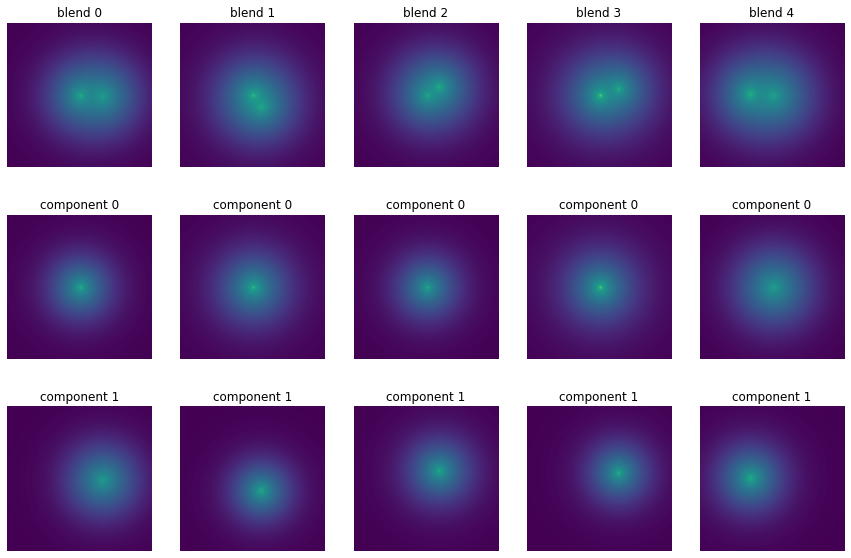

In [7]:
n=5
fig,ax=plt.subplots(3,n,figsize=(3*n, 10))
for i in range(n):
    showimg(blended[i],ax[0,i],f'blend {i}')
    for j in range(comps):
        showimg(components[j,i],ax[j+1,i],f'component {j}')  

In [8]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [9]:
def decoder(x):
    x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [10]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [11]:
#encoder
inputs=Input(shape=(height,width,1))

encoded=encoder(inputs)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

#decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

In [12]:
encode=Model(inputs,z)
encode.summary()

decode=Model([input_embed],[output1])
decode.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     18496       conv2d_1[0][0]                   
_______________________________________________________________________________________

In [13]:
encoding=encode(inputs) #define the network
re=decode([encoding])

vae=Model([inputs],[re]) #adds methods of the network
vae.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
functional_1 (Functional)    (None, 16)                73216     
_________________________________________________________________
functional_3 (Functional)    (None, 64, 64, 1)         106209    
Total params: 179,425
Trainable params: 179,425
Non-trainable params: 0
_________________________________________________________________


In [14]:
mse_loss=tf.reduce_mean(mse(inputs,re))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

vae.compile(optimizer=Adam(learning_rate=0.001))

In [15]:
history=vae.fit(components[0],verbose=1,epochs=100,batch_size=batch_size,validation_split=0.1)

Epoch 1/100
360/360 [==============================] - 9s 25ms/step - loss: 4.3643 - mse_loss: 4.1142 - kl_loss: 0.2500 - val_loss: 0.7660 - val_mse_loss: 0.5671 - val_kl_loss: 0.1989
Epoch 2/100
360/360 [==============================] - 9s 24ms/step - loss: 0.5231 - mse_loss: 0.3313 - kl_loss: 0.1918 - val_loss: 0.3487 - val_mse_loss: 0.1694 - val_kl_loss: 0.1793
Epoch 3/100
360/360 [==============================] - 9s 24ms/step - loss: 0.3317 - mse_loss: 0.1714 - kl_loss: 0.1603 - val_loss: 0.2722 - val_mse_loss: 0.1268 - val_kl_loss: 0.1454
Epoch 4/100
360/360 [==============================] - 9s 24ms/step - loss: 0.2797 - mse_loss: 0.1449 - kl_loss: 0.1348 - val_loss: 0.3343 - val_mse_loss: 0.2046 - val_kl_loss: 0.1297
Epoch 5/100
360/360 [==============================] - 9s 25ms/step - loss: 0.2715 - mse_loss: 0.1528 - kl_loss: 0.1187 - val_loss: 0.2238 - val_mse_loss: 0.1156 - val_kl_loss: 0.1082
Epoch 6/100
360/360 [==============================] - 9s 25ms/step - loss: 0.21

360/360 [==============================] - 9s 25ms/step - loss: 0.0805 - mse_loss: 0.0439 - kl_loss: 0.0366 - val_loss: 0.0952 - val_mse_loss: 0.0584 - val_kl_loss: 0.0368
Epoch 46/100
360/360 [==============================] - 9s 24ms/step - loss: 0.0794 - mse_loss: 0.0432 - kl_loss: 0.0362 - val_loss: 0.0782 - val_mse_loss: 0.0422 - val_kl_loss: 0.0360
Epoch 47/100
360/360 [==============================] - 9s 24ms/step - loss: 0.0739 - mse_loss: 0.0378 - kl_loss: 0.0361 - val_loss: 0.0659 - val_mse_loss: 0.0298 - val_kl_loss: 0.0362
Epoch 48/100
360/360 [==============================] - 9s 24ms/step - loss: 0.0784 - mse_loss: 0.0429 - kl_loss: 0.0356 - val_loss: 0.0573 - val_mse_loss: 0.0227 - val_kl_loss: 0.0346
Epoch 49/100
360/360 [==============================] - 9s 24ms/step - loss: 0.0689 - mse_loss: 0.0339 - kl_loss: 0.0350 - val_loss: 0.0650 - val_mse_loss: 0.0304 - val_kl_loss: 0.0346
Epoch 50/100
360/360 [==============================] - 9s 24ms/step - loss: 0.0768 - ms

360/360 [==============================] - 8s 23ms/step - loss: 0.0558 - mse_loss: 0.0271 - kl_loss: 0.0286 - val_loss: 0.0585 - val_mse_loss: 0.0282 - val_kl_loss: 0.0304
Epoch 90/100
360/360 [==============================] - 8s 23ms/step - loss: 0.0551 - mse_loss: 0.0265 - kl_loss: 0.0286 - val_loss: 0.0568 - val_mse_loss: 0.0269 - val_kl_loss: 0.0299
Epoch 91/100
360/360 [==============================] - 8s 23ms/step - loss: 0.0562 - mse_loss: 0.0277 - kl_loss: 0.0284 - val_loss: 0.0547 - val_mse_loss: 0.0261 - val_kl_loss: 0.0286
Epoch 92/100
360/360 [==============================] - 8s 23ms/step - loss: 0.0648 - mse_loss: 0.0362 - kl_loss: 0.0286 - val_loss: 0.0578 - val_mse_loss: 0.0285 - val_kl_loss: 0.0294
Epoch 93/100
360/360 [==============================] - 8s 23ms/step - loss: 0.0578 - mse_loss: 0.0296 - kl_loss: 0.0282 - val_loss: 0.0536 - val_mse_loss: 0.0255 - val_kl_loss: 0.0280
Epoch 94/100
360/360 [==============================] - 8s 23ms/step - loss: 0.0546 - ms

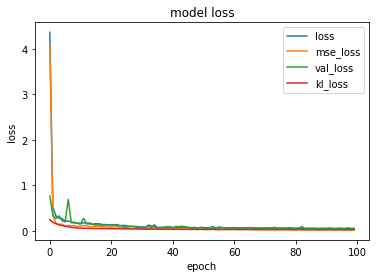

In [16]:
loss_plot(history)

In [17]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z])
    fig, ax = plt.subplots(3, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(output_img[i], ax[1, i], f'output\n{encoding}')
        showimg(output_img[i]-input_img[i], ax[2, i], f'output difference')
    return idx

[24 39 52 27 44]


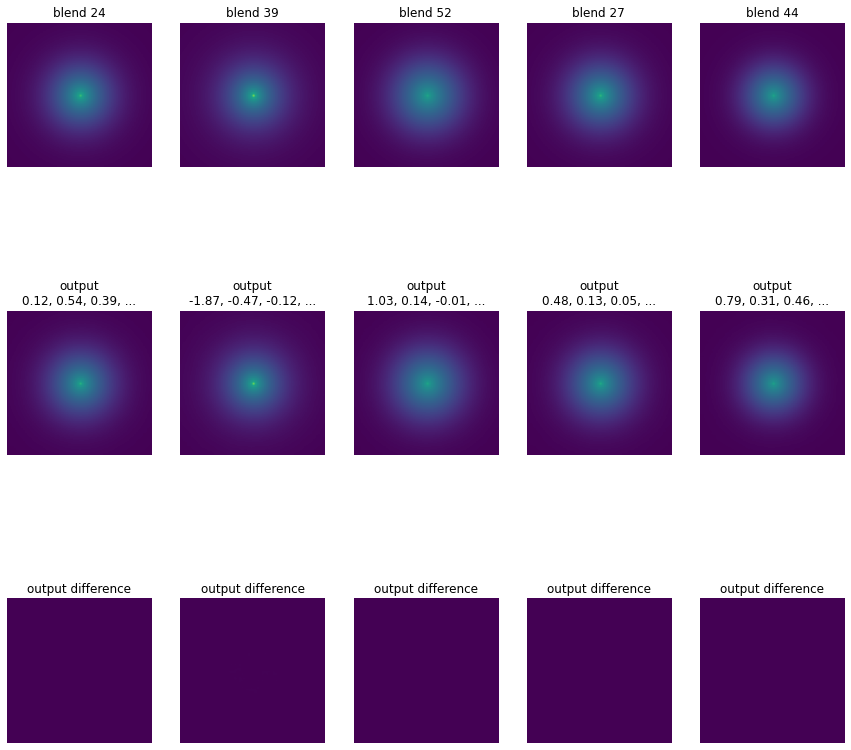

In [18]:
chosen=summary_plot(n,components[0],decode)

In [19]:
#encoder2
inputs2=Input(shape=(height,width,1))

encoded2=encoder(inputs2)
shape=encoded2.get_shape()[1:]
encoded2=Flatten()(encoded2)

z_mean2=Dense(latent_dimensions)(encoded2)
z_log_sigma2=Dense(latent_dimensions)(encoded2)
z2=Lambda(sampling)([z_mean2,z_log_sigma2])

In [20]:
encode2=Model(inputs2,z2)
encode2.summary()

input_compc=Input(shape=(height,width,1))

for layer in decode.layers:
    layer.trainable=False

decode.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 16, 16, 32)   9248        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 8, 8, 64)     18496       conv2d_5[0][0]                   
_______________________________________________________________________________________

In [21]:
encoding2=encode2(inputs2) #define the network
re2=decode([encoding2])

vae=Model([inputs2,input_compc],[re2]) #adds methods of the network
vae.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
functional_7 (Functional)       (None, 16)           73216       input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 64, 64, 1)    106209      functional_7[0][0]               
Total params: 179,425
Trainable params: 73,216
Non-trainable params: 106,209
__________

In [22]:
mse_loss=tf.reduce_mean(mse(input_compc,re2))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma2-tf.square(z_mean2)-tf.exp(z_log_sigma2)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

together=[blended,components[0]]
#together_v=[blended_v,components_v[0]]

vae.compile(optimizer=Adam(learning_rate=0.001))

In [23]:
history=vae.fit(together,verbose=1,epochs=100,batch_size=batch_size,validation_split=0.1)

Epoch 1/100
360/360 [==============================] - 8s 22ms/step - loss: 1.0231 - mse_loss: 0.9979 - kl_loss: 0.0252 - val_loss: 0.7280 - val_mse_loss: 0.6956 - val_kl_loss: 0.0324
Epoch 2/100
360/360 [==============================] - 7s 19ms/step - loss: 0.7357 - mse_loss: 0.7100 - kl_loss: 0.0257 - val_loss: 0.7250 - val_mse_loss: 0.7038 - val_kl_loss: 0.0212
Epoch 3/100
360/360 [==============================] - 7s 19ms/step - loss: 0.6795 - mse_loss: 0.6537 - kl_loss: 0.0258 - val_loss: 0.6418 - val_mse_loss: 0.6172 - val_kl_loss: 0.0245
Epoch 4/100
360/360 [==============================] - 7s 19ms/step - loss: 0.6504 - mse_loss: 0.6255 - kl_loss: 0.0249 - val_loss: 0.6546 - val_mse_loss: 0.6302 - val_kl_loss: 0.0244
Epoch 5/100
360/360 [==============================] - 7s 19ms/step - loss: 0.6383 - mse_loss: 0.6123 - kl_loss: 0.0260 - val_loss: 0.7279 - val_mse_loss: 0.7047 - val_kl_loss: 0.0233
Epoch 6/100
360/360 [==============================] - 7s 20ms/step - loss: 0.61

360/360 [==============================] - 7s 20ms/step - loss: 0.2573 - mse_loss: 0.2281 - kl_loss: 0.0291 - val_loss: 0.2502 - val_mse_loss: 0.2222 - val_kl_loss: 0.0280
Epoch 46/100
360/360 [==============================] - 7s 20ms/step - loss: 0.2440 - mse_loss: 0.2141 - kl_loss: 0.0300 - val_loss: 0.2645 - val_mse_loss: 0.2369 - val_kl_loss: 0.0275
Epoch 47/100
360/360 [==============================] - 7s 20ms/step - loss: 0.2357 - mse_loss: 0.2064 - kl_loss: 0.0293 - val_loss: 0.2453 - val_mse_loss: 0.2193 - val_kl_loss: 0.0260
Epoch 48/100
360/360 [==============================] - 7s 21ms/step - loss: 0.2369 - mse_loss: 0.2075 - kl_loss: 0.0294 - val_loss: 0.3200 - val_mse_loss: 0.2893 - val_kl_loss: 0.0306
Epoch 49/100
360/360 [==============================] - 7s 20ms/step - loss: 0.2256 - mse_loss: 0.1968 - kl_loss: 0.0288 - val_loss: 0.2481 - val_mse_loss: 0.2180 - val_kl_loss: 0.0301
Epoch 50/100
360/360 [==============================] - 7s 20ms/step - loss: 0.2376 - ms

360/360 [==============================] - 7s 19ms/step - loss: 0.1744 - mse_loss: 0.1455 - kl_loss: 0.0289 - val_loss: 0.2394 - val_mse_loss: 0.2072 - val_kl_loss: 0.0322
Epoch 90/100
360/360 [==============================] - 7s 20ms/step - loss: 0.1777 - mse_loss: 0.1485 - kl_loss: 0.0292 - val_loss: 0.2424 - val_mse_loss: 0.2119 - val_kl_loss: 0.0306
Epoch 91/100
360/360 [==============================] - 7s 20ms/step - loss: 0.1678 - mse_loss: 0.1394 - kl_loss: 0.0284 - val_loss: 0.2195 - val_mse_loss: 0.1911 - val_kl_loss: 0.0285
Epoch 92/100
360/360 [==============================] - 7s 19ms/step - loss: 0.1723 - mse_loss: 0.1443 - kl_loss: 0.0280 - val_loss: 0.3027 - val_mse_loss: 0.2726 - val_kl_loss: 0.0300
Epoch 93/100
360/360 [==============================] - 7s 20ms/step - loss: 0.1739 - mse_loss: 0.1447 - kl_loss: 0.0292 - val_loss: 0.2382 - val_mse_loss: 0.2079 - val_kl_loss: 0.0303
Epoch 94/100
360/360 [==============================] - 7s 19ms/step - loss: 0.1747 - ms

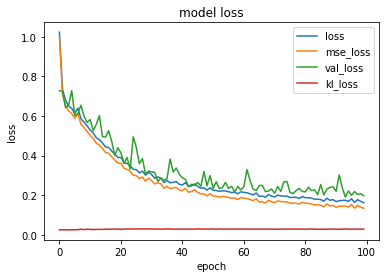

In [24]:
loss_plot(history)

In [25]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    compc=inputs[1][idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z,compc])
    fig, ax = plt.subplots(5, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(compc[i], ax[1, i], f'comp1 {idx[i]}')
        showimg(output_img[i], ax[2, i], f'output\n{encoding}')
        showimg(output_img[i]-compc[i], ax[3, i], f'output difference')
        showimg(input_img[i]-output_img[i], ax[4, i], f'original difference')
    return idx

[ 200 1078  610 2159 1169]


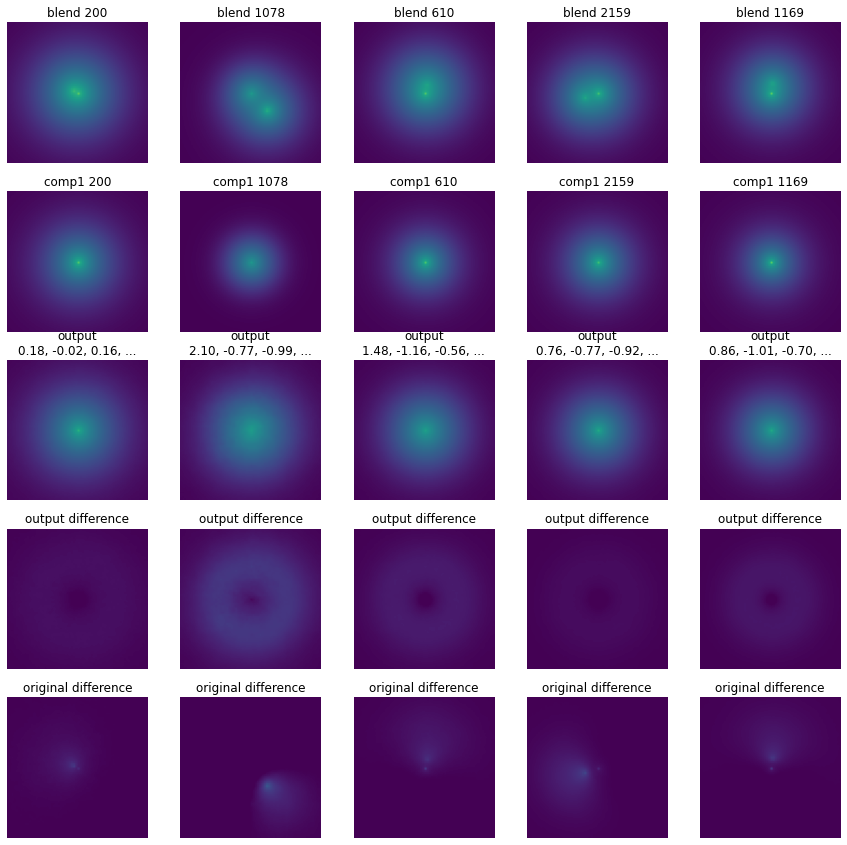

In [26]:
chosen=summary_plot(n,together,decode)

(Text(0.5, 0, 'Loss'), Text(0, 0.5, 'Frequency'))

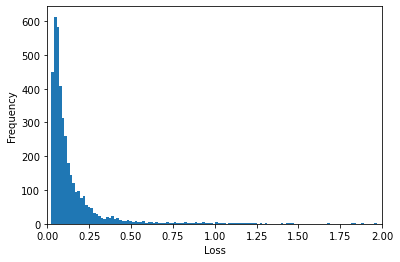

In [29]:
losses=np.zeros(num)
for ite in range(0,num):
    input_img=blended[ite]
    compc=components[0,ite]

    input_img=input_img.reshape(1,height,width,1).astype('float32')
    compc=compc.reshape(1,height,width,1).astype('float32')

    evals=vae.evaluate([input_img,compc],verbose=0,batch_size=batch_size)
    losses[ite]=evals[0]
    #print(ite)
    
loss_max=np.amax(losses)
ax=plt.axes()
ax.hist(losses,bins=300)
ax.set_xlim(0,min(loss_max,2)),ax.set_ylim(0)
ax.set_xlabel("Loss"),ax.set_ylabel("Frequency")

In [28]:
vae.save("model_1.h5")

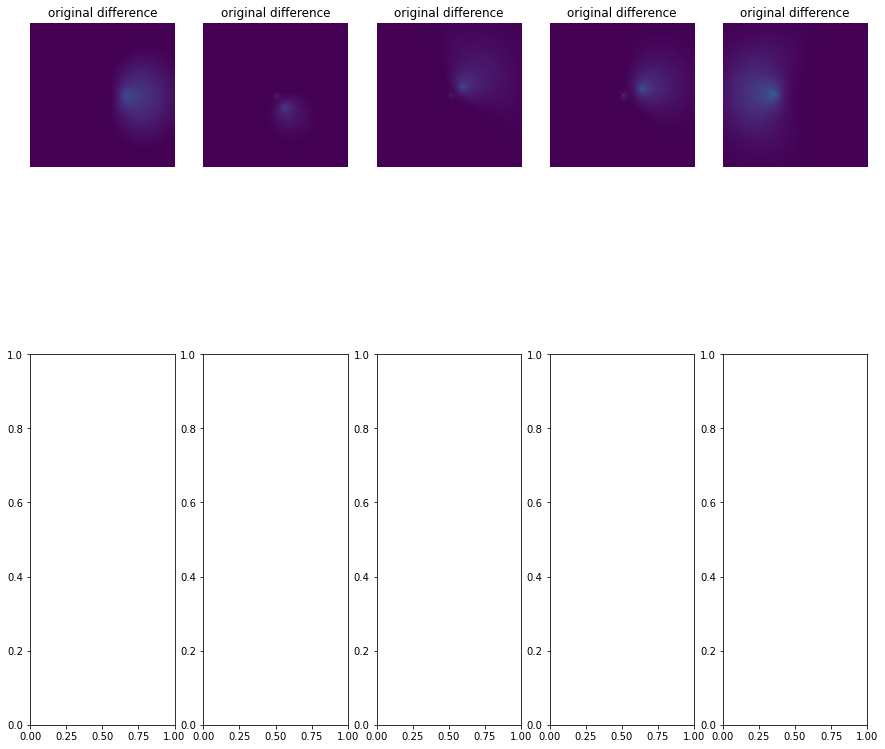

In [33]:
fig,ax = plt.subplots(2,n,figsize=((3)*n,15))
idx=np.array([0,1,2,3,4])

input_img = together[0][idx]
compc=together[1][idx]
z = encode.predict(input_img)
output_img = decode.predict([z,compc])

for i in range(n):
    showimg(input_img[i]-output_img[i], ax[0,i] , f'original difference')
